# Feature Engineering - FEMA Large Disasters with Demographics

In [1]:
# Basic libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import warnings

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Options
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

### Load FEMA Data

In [3]:
# Load FEMA data
flData = pd.read_csv("../../../data/open-fema/FEMA-Large-DR-4337-FL.csv")
txData = pd.read_csv("../../../data/open-fema/FEMA-Large-DR-4332-TX.csv")
prData = pd.read_csv("../../../data/open-fema/FEMA-Large-DR-4339-PR.csv")

In [4]:
# Combine FL + PR + TX datasets
femaDf = pd.concat([flData, txData, prData])
print(f"There are {len(femaDf)} records in the dataframe.")

There are 4661523 records in the dataframe.


In [5]:
# Look at data types for each of the columns
femaDf.dtypes

disasterNumber                       int64
damagedCity                         object
damagedStateAbbreviation            object
damagedZipCode                     float64
householdComposition                 int64
grossIncome                        float64
specialNeeds                          bool
ownRent                             object
residenceType                       object
homeOwnersInsurance                   bool
floodInsurance                        bool
inspected                             bool
rpfvl                              float64
habitabilityRepairsRequired         object
destroyed                             bool
waterLevel                         float64
floodDamage                           bool
foundationDamage                      bool
foundationDamageAmount             float64
roofDamage                            bool
roofDamageAmount                   float64
tsaEligible                           bool
tsaCheckedIn                          bool
rentalAssis

In [6]:
femaDf.drop_duplicates(inplace=True)
print(f"There are {len(femaDf)} records after dropping any duplicates.")

There are 4661523 records after dropping any duplicates.


In [7]:
# Change incorrect datatype
femaDf['habitabilityRepairsRequired'] = femaDf['habitabilityRepairsRequired'].astype('bool')
femaDf['primaryResidence'] = femaDf['primaryResidence'].astype('bool')
femaDf['censusBlockId'] = femaDf['censusBlockId'].astype('str').replace('\.0', '', regex=True)
print(f"habitabilityRepairsRequired datatype: {femaDf['habitabilityRepairsRequired'].dtype}")
print(f"primaryResidence datatype: {femaDf['primaryResidence'].dtype}")
print(f"censusBlockId datatype: {femaDf['censusBlockId'].dtype}")

habitabilityRepairsRequired datatype: bool
primaryResidence datatype: bool
censusBlockId datatype: object


In [8]:
# Create census tract IDs for FEMA dataset
femaDf['censusTractId'] = femaDf.apply(lambda row: row.censusBlockId[0:11], axis=1)
femaDf[['censusBlockId', 'censusTractId']].head()

censusBlockId censusTractId
0  120111105011006   12011110501
1  120860011032003   12086001103
2  120830012043000   12083001204
3  120860135002000   12086013500
4  120090641241018   12009064124

In [9]:
# Create county FIPS codes
femaDf['fips'] = femaDf.apply(lambda row: row.censusBlockId[0:5], axis=1)
femaDf[['censusTractId', 'fips']].head()

censusTractId   fips
0   12011110501  12011
1   12086001103  12086
2   12083001204  12083
3   12086013500  12086
4   12009064124  12009

### Load Census Demographics

In [10]:
# Load demographics data
demoDf = pd.read_csv("../../../data/census-tract/census-tract-demographics.csv")
demoDf.head(3)

censusid         gisjoin      tractid  \
0  1400000US12001000200  G1200010000200  12001000200   
1  1400000US12001000301  G1200010000301  12001000301   
2  1400000US12001000302  G1200010000302  12001000302   

                                    tractname          county    state  \
0     Census Tract 2, Alachua County, Florida  Alachua County  Florida   
1  Census Tract 3.01, Alachua County, Florida  Alachua County  Florida   
2  Census Tract 3.02, Alachua County, Florida  Alachua County  Florida   

   total_population  male_population  female_population  total_population_edu  \
0              6834             3096               3738                  1941   
1              3849             1806               2043                  2443   
2              2374             1151               1223                  1700   

   high_school_grad  bachelors_degree  graduate_prof_degree  \
0               564               256                   479   
1               467               570                   440   
2               464               246                   194   

   high_school_grad_rate  bachelors_degree_rate  graduate_prof_degree_rate  \
0               0.290572               0.131891                   0.246780   
1               0.191158               0.233320                   0.180106   
2               0.272941               0.144706                   0.114118   

   bachelors_plus_degree_rate  total_population_employ  labor_force_total  \
0                    0.378671                     6681               3151   
1                    0.413426                     3499               2397   
2                    0.258824                     2047               1241   

   civilian_labor_force  employed_labor_force  unemployed_labor_force  \
0                  3147                  2923                     224   
1                  2397                  2161                     236   
2                  1241                  1064                     177   

   armed_forces_labor_force  not_labor_force_total  labor_force_rate  \
0                         4                   3530          0.471636   
1                         0                   1102          0.685053   
2                         0                    806          0.606253   

   civilian_labor_rate  employed_labor_rate  unemployed_labor_rate  \
0             0.471037             0.437509               0.033528   
1             0.685053             0.617605               0.067448   
2             0.606253             0.519785               0.086468   

   armed_forces_labor_rate  not_labor_force_rate  total_population_income  \
0                 0.000599              0.528364                      345   
1                 0.000000              0.314947                      592   
2                 0.000000              0.393747                      433   

   income_less_10k  income_10k_15k  income_15k_20k  income_20k_25k  \
0               28              49              30               0   
1               55              71              12              63   
2                8              22              12             106   

   income_25k_30k  income_30k_35k  income_35k_40k  income_40k_45k  \
0               0              31               0               0   
1               5              10              53              39   
2              24              29              19               0   

   income_45k_50k  income_50k_60k  income_60k_75k  income_75k_100k  \
0               0              71              49               14   
1              66              55              24               86   
2              13              34              57               22   

   income_100k_125k  income_125k_150k  income_150k_200k  income_200k_more  \
0                21                30                22                 0   
1                 0                14                23                16   
2                41                23              

In [11]:
# Check vars in index
print(demoDf.columns)

Index(['censusid', 'gisjoin', 'tractid', 'tractname', 'county', 'state',
       'total_population', 'male_population', 'female_population',
       'total_population_edu',
       ...
       'total_native_rate', 'native_in_state_rate', 'native_out_state_rate',
       'native_outside_us_rate', 'native_outside_us_puerto_rate',
       'native_outside_us_islands_rate', 'native_outside_us_abroad_rate',
       'total_foreign_rate', 'foreign_citizen_rate',
       'foreign_non_citizen_rate'],
      dtype='object', length=250)


In [12]:
# Change to tractid datatype to string
demoDf['tractid'] = demoDf['tractid'].astype('str')
print(f"tractid datatype: {demoDf['tractid'].dtype}")

tractid datatype: object


In [13]:
# Select subset of variables
demoDf = demoDf[['censusid', 'tractid', 'tractname', 'county', 'state', 'below_poverty_rate', 'median_earnings_total',
                 'unemployed_labor_rate', 'built_1979_or_earlier_rate', 'owner_occupied_rate']]

demoDf.head(3)

censusid      tractid  \
0  1400000US12001000200  12001000200   
1  1400000US12001000301  12001000301   
2  1400000US12001000302  12001000302   

                                    tractname          county    state  \
0     Census Tract 2, Alachua County, Florida  Alachua County  Florida   
1  Census Tract 3.01, Alachua County, Florida  Alachua County  Florida   
2  Census Tract 3.02, Alachua County, Florida  Alachua County  Florida   

   below_poverty_rate  median_earnings_total  unemployed_labor_rate  \
0            0.561760                 6752.0               0.033528   
1            0.347230                20481.0               0.067448   
2            0.244323                25108.0               0.086468   

   built_1979_or_earlier_rate  owner_occupied_rate  
0                    0.412270             0.176396  
1                    0.630089             0.205597  
2                    0.834117             0.425976

### Combine Demographics with FEMA data

In [14]:
# Merge demographics and FEMA datasets
df = pd.merge(femaDf, demoDf, left_on='censusTractId', right_on='tractid')

In [15]:
# Check how many rows we have in the merged dataframe
print(f"There are {len(df)} records in the merged dataset.")
print(f"This is a {len(femaDf) - len(df)} difference b/w the original dataset and the merged.")

There are 4602394 records in the merged dataset.
This is a 59129 difference b/w the original dataset and the merged.


In [16]:
# Check how many census tracts are represented between TX & FL
print(f"There are {len(df['tractid'].unique())} tracts represented in the dataset.")
print(f"Of these, {len(df.loc[df['damagedStateAbbreviation'] == 'PR', 'censusid'].unique())} are from PR.")
print(f"Of these, {len(df.loc[df['damagedStateAbbreviation'] == 'TX', 'censusid'].unique())} are from TX.")
print(f"Of these, {len(df.loc[df['damagedStateAbbreviation'] == 'FL', 'censusid'].unique())} are from FL.")

There are 7512 tracts represented in the dataset.
Of these, 896 are from PR.
Of these, 2461 are from TX.
Of these, 4158 are from FL.


### HUD Fair Market Rates

In [18]:
# Load HUD Fair Market Rates
hudDf = pd.read_csv("../../../data/hud/HUD-FMR-with-demo.csv")
hudDf.head(3)

fips          county  occupied_housing_units_rate  \
0  12001  Alachua County                     0.845622   
1  12003    Baker County                     0.843566   
2  12005      Bay County                     0.676942   

   vacant_housing_units_rate  owner_occupied_rate  fmr0  fmr1  fmr2  fmr3  \
0                   0.154378             0.536000   624   717   878  1177   
1                   0.156434             0.775877   477   645   752   951   
2                   0.323058             0.624478   693   813   949  1359   

   fmr4  metro  
0  1339      1  
1  1266      1  
2  1609      1

In [19]:
# Check vars in index
print(hudDf.columns)

Index(['fips', 'county', 'occupied_housing_units_rate',
       'vacant_housing_units_rate', 'owner_occupied_rate', 'fmr0', 'fmr1',
       'fmr2', 'fmr3', 'fmr4', 'metro'],
      dtype='object')


In [20]:
# Change to tractid datatype to string
hudDf['fips'] = hudDf['fips'].astype('str')
print(f"fips datatype: {hudDf['fips'].dtype}")

fips datatype: object


In [21]:
# Select subset of variables
hudDf = hudDf[['fips', 'fmr0', 'fmr1', 'fmr2', 'fmr3', 'fmr4',
                 'occupied_housing_units_rate', 'vacant_housing_units_rate', 'owner_occupied_rate']]

hudDf.head(3)

fips  fmr0  fmr1  fmr2  fmr3  fmr4  occupied_housing_units_rate  \
0  12001   624   717   878  1177  1339                     0.845622   
1  12003   477   645   752   951  1266                     0.843566   
2  12005   693   813   949  1359  1609                     0.676942   

   vacant_housing_units_rate  owner_occupied_rate  
0                   0.154378             0.536000  
1                   0.156434             0.775877  
2                   0.323058             0.624478

### Combine HUD with FEMA Data

In [22]:
# Original file size
original_len = len(df)

# Merge HUD and FEMA datasets
df = pd.merge(df, hudDf, left_on='fips', right_on='fips')

print(f"There are {len(df)} records in the dataset merged with HUD.")
print(f"This is a {original_len - len(df)} difference b/w the original dataset and the merged.")

There are 4602394 records in the dataset merged with HUD.
This is a 0 difference b/w the original dataset and the merged.


### Feature Engineering

In [23]:
# Define all dollar amount columns
amountCols = ['foundationDamageAmount', 'roofDamageAmount', 'rentalAssistanceAmount', 
              'replacementAmount','repairAmount', 'rpfvl', 'ppfvl']

# Set them to zero if null
df[amountCols] = df[amountCols].fillna(0)

# Calculate the aggregated haAmount
df['haAmount'] = df['rentalAssistanceAmount'] + df['replacementAmount'] + df['repairAmount']

print('Total ${:,.2f} in HA rental payouts'.format(df['rentalAssistanceAmount'].sum()))
print('Total ${:,.2f} in mainland HA rental payouts'.format(df.loc[df['damagedStateAbbreviation'] != 'PR', 'rentalAssistanceAmount'].sum()))

Total $955,634,310.05 in HA rental payouts
Total $836,467,709.63 in mainland HA rental payouts


In [24]:
# Convert boolean columns to int
bool_cols = ['specialNeeds', 'homeOwnersInsurance', 'floodInsurance', 'inspected', 'destroyed', 
             'habitabilityRepairsRequired', 'floodDamage', 'foundationDamage', 'roofDamage', 
             'tsaEligible', 'rentalAssistanceEligible', 'repairAssistanceEligible', 
             'replacementAssistanceEligible', 'sbaEligible', 'primaryResidence']

df[bool_cols] = df[bool_cols].astype(int)

In [25]:
# Fill the na's with zero's in waterLevel 
df['waterLevel'].fillna(0, inplace=True)

In [26]:
# One-hot encode the categorical variables
cat_cols = ['ownRent', 'residenceType']
for col in cat_cols:
    df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
df.drop(cat_cols, axis=1, inplace=True)

### Create Train and Test - With Outliers

In [28]:
# Train (FL/TX) data
trainDf = df.loc[df['damagedStateAbbreviation'] != 'PR', ]

# Write train to csv
trainDf.to_csv("../../../data/open-fema/experimental/rental/FEMA-Large-Demographics-FL-TX.csv", index=False, encoding='utf-8')
print('Train (FL/TX) rows:', len(trainDf))

Train (FL/TX) rows: 3535319


In [29]:
# Test (PR) data
testDf = df.loc[df['damagedStateAbbreviation'] == 'PR', ]

# Write test to csv
testDf.to_csv("../../../data/open-fema/experimental/rental/FEMA-Large-Demographics-PR.csv", index=False, encoding='utf-8')
print('Test (PR) rows:', len(testDf))

Test (PR) rows: 1067075


### Treat Outliers

In [30]:
# Do drop uninspected with HA amount
print(f"Expected amount of rows after dropped: {len(df) - len(df[(df['haAmount']>0) & (df['inspected']==False)])}")
uninspected = df.loc[(df['haAmount'] > 0) & (df['inspected'] == False)].index
df.drop(uninspected, inplace=True)
print(f"Amount after dropped: {len(df)}")

Expected amount of rows after dropped: 4229511
Amount after dropped: 4229511


In [31]:
# Drop those with HA amount over max
print(f"Expected amount of rows after dropped: {len(df) - len(df[(df['haAmount'] > 33300)])}")
maxLimit_ha = df.loc[(df['haAmount'] > 33300)].index
df.drop(maxLimit_ha, inplace=True)
print(f"Amount after dropped: {len(df)}")

Expected amount of rows after dropped: 4229498
Amount after dropped: 4229498


In [32]:
# Drop those with household composition over 15
print(f"Expected amount of rows after dropped: {len(df) - len(df[(df['householdComposition'] > 15)])}")
maxLimit_house = df.loc[(df['householdComposition'] > 15)].index
df.drop(maxLimit_house, inplace=True)
print(f"Amount after dropped: {len(df)}")

Expected amount of rows after dropped: 4229436
Amount after dropped: 4229436


In [33]:
# Drop those with water level over 120
print(f"Expected amount of rows after dropped: {len(df) - len(df[(df['waterLevel'] > 120)])}")
maxLimit_water = df.loc[(df['waterLevel'] > 120)].index
df.drop(maxLimit_water, inplace=True)
print(f"Amount after dropped: {len(df)}")

Expected amount of rows after dropped: 4229030
Amount after dropped: 4229030


### Create Train and Test - Outliers Removed

In [34]:
# Create train without outliers
trainDf = df.loc[df['damagedStateAbbreviation'] != 'PR', ]

# Write train to csv
trainDf.to_csv("../../../data/open-fema/experimental/rental/FEMA-Large-Demographics-FL-TX-clean.csv", index=False, encoding='utf-8')
print('Train (FL/TX) rows:', len(trainDf))

Train (FL/TX) rows: 3187285


In [35]:
# Create test without outliers
testDf = df.loc[df['damagedStateAbbreviation'] == 'PR', ]

# Write test to csv
testDf.to_csv("../../../data/open-fema/experimental/rental/FEMA-Large-Demographics-PR-clean.csv", index=False, encoding='utf-8')
print('Test (PR) rows:', len(testDf))

Test (PR) rows: 1041745


### householdComposition vs. rentalAssistanceAmount

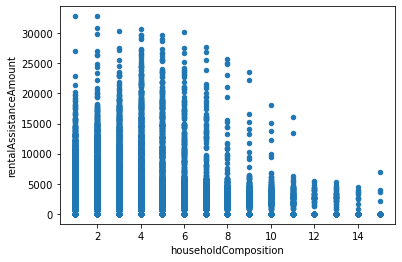

In [36]:
trainDf.plot(x='householdComposition', y='rentalAssistanceAmount', kind='scatter')